# Machine Learning Project

In this project, I am tring to implement [Generative Adverserarial Nets (GAN)](https://arxiv.org/pdf/1710.07035.pdf)  for digit and Face generation. GAN's are very exciting algorithms and used today from generating celebrity faces,   generating artisting imagesto generate audio signals.

Porting some packages 

In [44]:
import random
import numpy as np
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

Importing Digit DataSet and doing preprocessing for model training. For the preprocessing step, I scaled the data from [-0.5, 0.5].

In [45]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
Xdig = mnist.data
ydig = mnist.target
Xdigs = 2*(Xdig/(np.max(Xdig)))-1
Xdigs = Xdigs/2

Function to port few samples from training dataset for training. Ideally it should be train on all the samples 
but it is taking lot of time to train so we took few percentage of data from all the digits

# Preprocessing Data

In [46]:
def dataSet(percent):
    sum = 0 
    minInd = 0
    TrainInd = [] 
    for i in range(10):
        a = np.where(ydig==i)
        length = a[0].shape[0]
        total = int(length * (percent/100))
        for i in range(total):
            TrainInd.append(a[0][i])
        sum = sum + total

    #print(len(TrainInd), sum)
    Xtrain = Xdigs[TrainInd, :]
    return Xtrain

Getting the dataset for traing and printing size

In [47]:
Xtrain = dataSet(5)
nTrain, nFeatures = Xtrain.shape
print('trainSize', nTrain, 'Features', nFeatures)

trainSize 3495 Features 784


# Function to display digits

In [48]:
def plt_digit(x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq, cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    

Checking Function for displaying

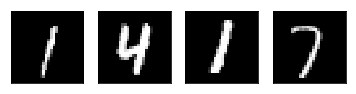

In [49]:
nplt = 4
nsamp = Xdigs.shape[0]
for i in range(nplt):
    ind = randint(0,nsamp-1)
    plt.subplot(1,nplt,i+1)
    plt_digit(Xdig[ind,:])

# importing Keras model layers

In [50]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, LeakyReLU
from keras.layers import Conv2D
from keras.layers import Activation
from keras.optimizers import SGD, Adam

import keras.backend as K
K.clear_session()


# Model Gereration

# Discriminator Model

This model try to distinguish between samples generated are from real distribution or generated distribution. 

In [51]:
inputShape = (nFeatures,)
dModel = Sequential()
dModel.add(Dense(256, input_shape=inputShape, activation='tanh'))
dModel.add(Dense(256,   activation= 'tanh'))
dModel.add(Dense(1, activation = 'sigmoid'))
dModel.summary()

#Compile the model
#dOpt = Adam(lr=2e-3)
#dModel.compile(loss='binary_crossentropy',optimizer=dOpt,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
_________________________________________________________________


# Generator Model

This model tries to generate samples which look like real samples and try to fool the discriminator

In [52]:
randomDim = 100
gModel = Sequential()
gModel.add(Dense(1024, input_shape=(randomDim,), activation='tanh'))
gModel.add(Dense(1024, activation='tanh'))
gModel.add(Dense(784, activation = 'tanh'))  
  
gModel.summary()

#gOpt = Adam(lr=1e-1)
#gModel.compile(loss='categorical_crossentropy',optimizer=gOpt,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 784)               803600    
Total params: 1,956,624
Trainable params: 1,956,624
Non-trainable params: 0
_________________________________________________________________


# Discriminator Inside Generator 

This model appends discriminator inside the generator for training purposes. 
It is very important here make discriminator layers training false here so that they are 
not training while training generator else they will understand at each step what generator is doing.

In [53]:
gModelTrain = Sequential()
for layer in gModel.layers:
    gModelTrain.add(layer)
    
for layer in dModel.layers:
    layer.trainable = False 
    gModelTrain.add(layer)
       
gModelTrain.summary() 


#gModelTrain.compile(loss='binary_crossentropy',optimizer=gOpt,metrics=['accuracy'])    
#for layer in gModelTrain.layers:
#    print(layer.trainable)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 784)               803600    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,223,633
Trainable params: 1,956,624
Non-trainable params: 267,009
____________________________________________________________

# Model compilation

In [54]:
#compile
gOpt = SGD(lr=1e-4,  momentum=0.9, nesterov=True)
gModel.compile(loss='categorical_crossentropy',optimizer="SGD")

gOptT = SGD(lr=1e-4,  momentum=0.9, nesterov=True)
gModelTrain.compile(loss='binary_crossentropy',optimizer=gOptT)    

for layer in dModel.layers:
    layer.trainable = True
   
dOpt = SGD(lr=1e-4,  momentum=0.9, nesterov=True)
dModel.compile(loss='binary_crossentropy',optimizer=dOpt)


# Function to test generator It also saves the intermediate results

In [55]:
def testGenerator(images, rows, cols, epoch, start):
    noise = np.random.normal(0,1, [images,100])
    out = gModel.predict(noise)
    fig = plt.figure(figsize=(8,8))
    for i in range(images):
        plt.subplot(rows,cols,i+1)
        plt_digit((out[i,:]*2 +1)/2)
        
    fig.savefig(str(start+epoch)+'.png')

# Training Models

This function runs Trains both generative and discriminative models per batch. The important things to consider here are:

1). Discriminator model take both real and fake samples in each batch.


2). Generative samples mark samples as Real to fool the discriminator and learn from mistakes.


3). Make sure where the discriminator models layers are training and where not.


4). In paper they talk about training discriminator multiple times but I trained only once due to time constraint.

In [56]:
def runAdversialNet(epochs, batchSize, lossDE, lossGE, accuDE, accuGE, start):
    for i in range(epochs):
        trainIdx = random.sample(range(0,nTrain), nTrain)
        #print(trainIdx)
        lossD = 0
        accuD = 0
        lossG = 0
        accuG = 0
        nBatch = nTrain/batchSize
        for j in range(0, nTrain-batchSize, batchSize):
            #disminicrator Training
            XData = Xtrain[trainIdx[j:j+batchSize],:]  
            noise = np.random.normal(0,1, [batchSize,100])
            gData = gModel.predict(noise)

            trainBatchD = np.concatenate((XData, gData))
            labelD = np.zeros([2*batchSize])
            labelD[0:batchSize] = 1  #Real
            labelD[batchSize:] = 0   #Fake
            
            dModel.trainable = True
            lossDB  = dModel.train_on_batch(trainBatchD, labelD)
            
            #Generator Training
            noiseG = np.random.normal(0,1, [batchSize,100])
            labelG = np.zeros([batchSize])
            #Fake is going Real to fool discriminator
            labelG[0:batchSize] = 1    
            dModel.trainable = False
            lossGB = gModelTrain.train_on_batch(noise, labelG)
            lossD = lossD + lossDB
            lossG = lossG + lossGB
            
        lossDE.append(lossD/(nBatch))
        lossGE.append(lossG/nBatch)
        #print('epoch ', i, 'lossD', lossD/(nBatch), 'accuD', accuD/nBatch, 'lossG', lossG/nBatch, 'accuG', accuG/nBatch)    
        print('epoch ', i, 'lossD', lossD/(nBatch), 'lossG', lossG/nBatch)      
        if(i%10 == 0):
            testGenerator(16, 4, 4, i, start)

Maiintain some logs from plotting

In [57]:
lossDE = []
accuDE = []
lossGE = []
accuGE = []

# Training the model

epoch  0 lossD 0.486106620428 lossG 0.673199007201
epoch  1 lossD 0.443586573785 lossG 0.606967265139
epoch  2 lossD 0.459557527534 lossG 0.558782382141
epoch  3 lossD 0.46907659266 lossG 0.535615466422
epoch  4 lossD 0.475920992348 lossG 0.521357670294
epoch  5 lossD 0.473974766547 lossG 0.522374902706
epoch  6 lossD 0.463756141608 lossG 0.537134711903
epoch  7 lossD 0.447576215032 lossG 0.562453299701
epoch  8 lossD 0.427222319563 lossG 0.596995295032
epoch  9 lossD 0.403237162196 lossG 0.641476576318
epoch  10 lossD 0.379917484223 lossG 0.689068809804
epoch  11 lossD 0.355741799918 lossG 0.743520486747
epoch  12 lossD 0.335424499894 lossG 0.794401060222
epoch  13 lossD 0.315624863566 lossG 0.848493060875
epoch  14 lossD 0.300968707716 lossG 0.89259414782
epoch  15 lossD 0.288945705867 lossG 0.931744327463
epoch  16 lossD 0.280948113372 lossG 0.960817571703
epoch  17 lossD 0.274453929634 lossG 0.986966003505
epoch  18 lossD 0.272602850514 lossG 0.999176825986
epoch  19 lossD 0.272094

/home/manoj15/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch  201 lossD 0.692724391626 lossG 0.695546748062
epoch  202 lossD 0.689699618295 lossG 0.699769592831
epoch  203 lossD 0.684788678542 lossG 0.706885831448
epoch  204 lossD 0.680542179921 lossG 0.711030793633
epoch  205 lossD 0.67671436479 lossG 0.716026057842
epoch  206 lossD 0.677225604078 lossG 0.716044667998
epoch  207 lossD 0.676519054473 lossG 0.720878118643
epoch  208 lossD 0.677609990765 lossG 0.719421774737
epoch  209 lossD 0.676660100585 lossG 0.722662440288
epoch  210 lossD 0.680875583916 lossG 0.717321402423
epoch  211 lossD 0.685979856783 lossG 0.713830200763
epoch  212 lossD 0.695901193469 lossG 0.703190248787
epoch  213 lossD 0.705049659936 lossG 0.691930217497
epoch  214 lossD 0.713183550637 lossG 0.685927360764
epoch  215 lossD 0.72218859049 lossG 0.674329933963
epoch  216 lossD 0.72289878998 lossG 0.676100788471
epoch  217 lossD 0.723594061397 lossG 0.672817521648
epoch  218 lossD 0.721113258984 lossG 0.677060450607
epoch  219 lossD 0.716824235493 lossG 0.681847701

TypeError: testGenerator() missing 1 required positional argument: 'start'

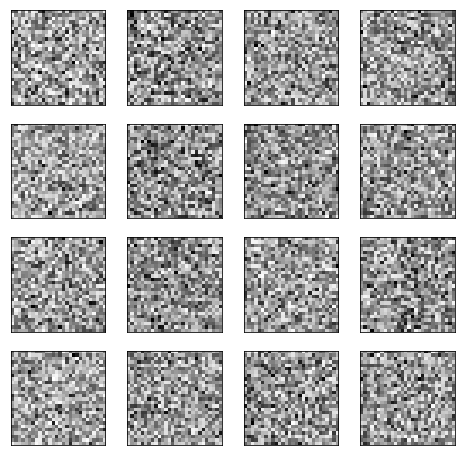

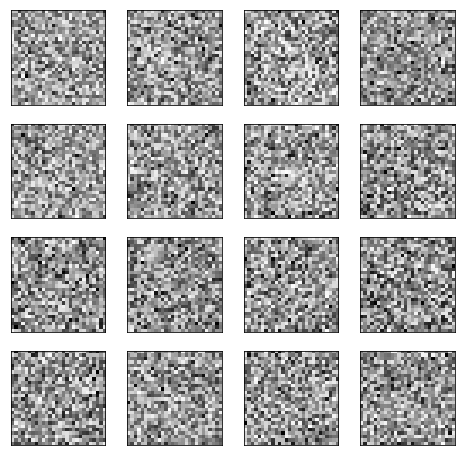

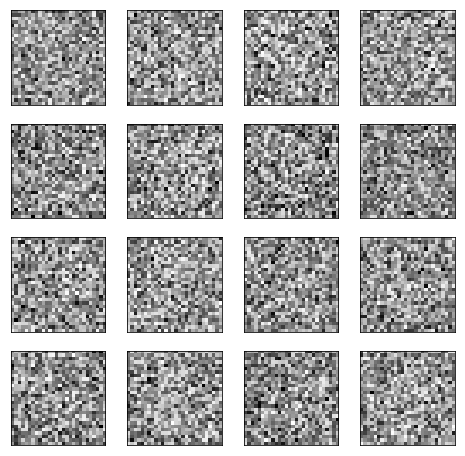

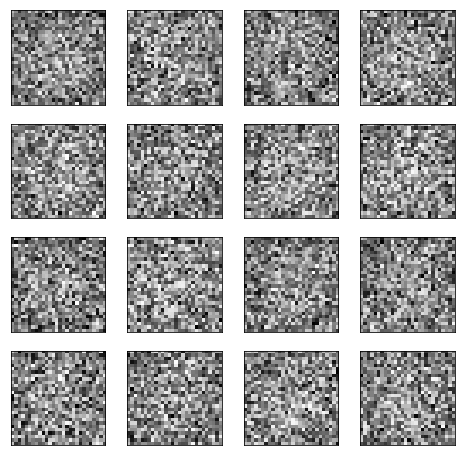

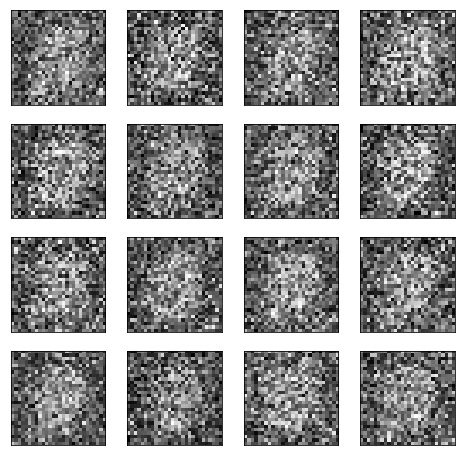

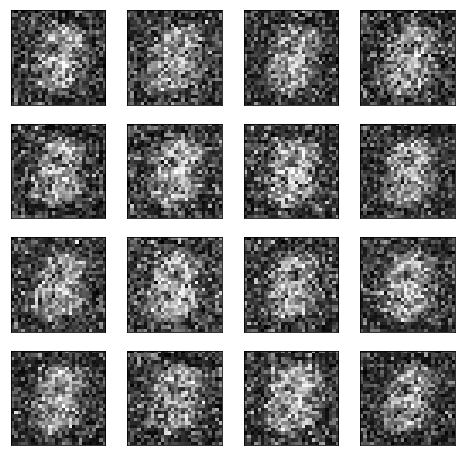

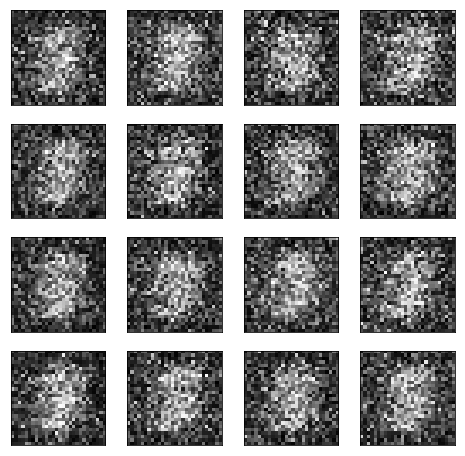

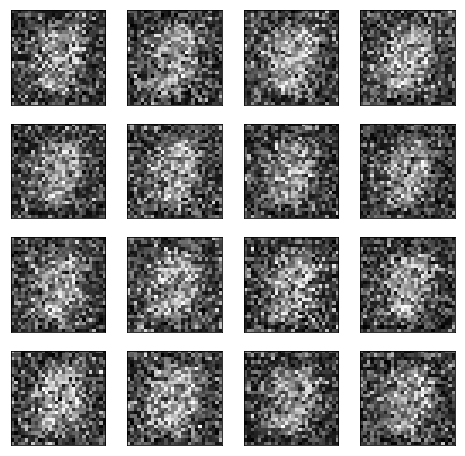

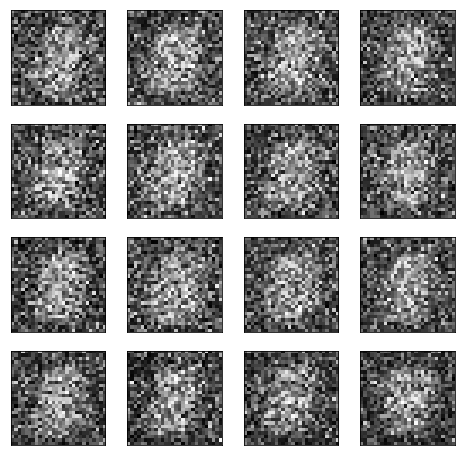

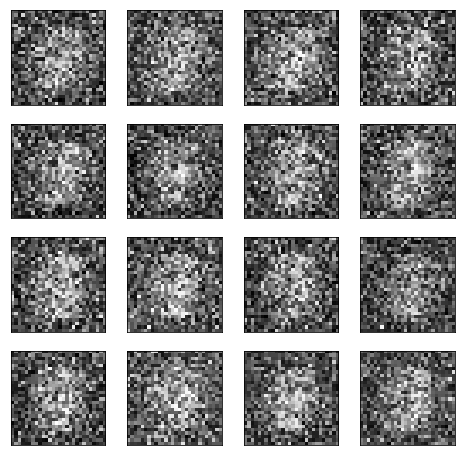

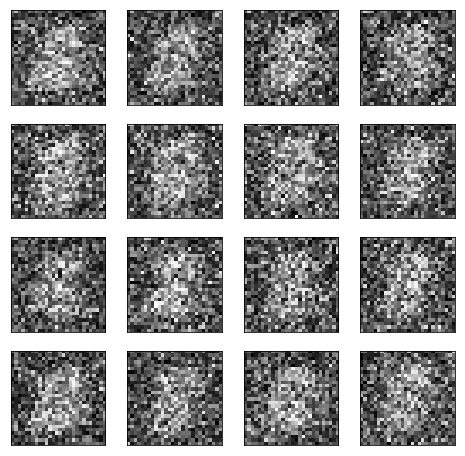

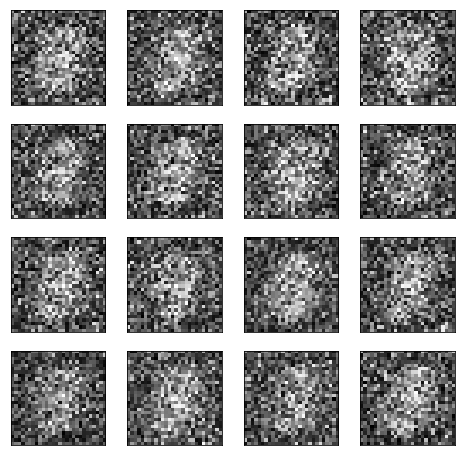

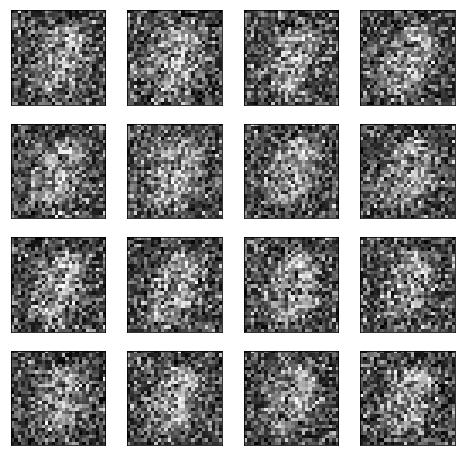

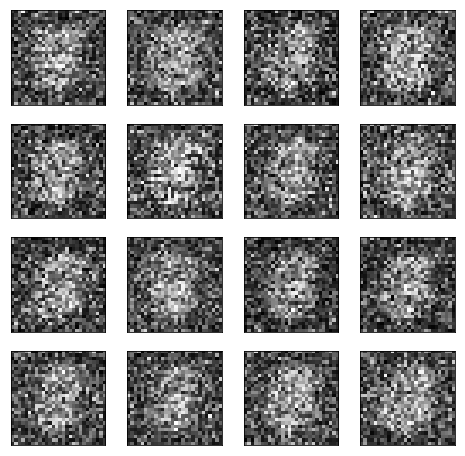

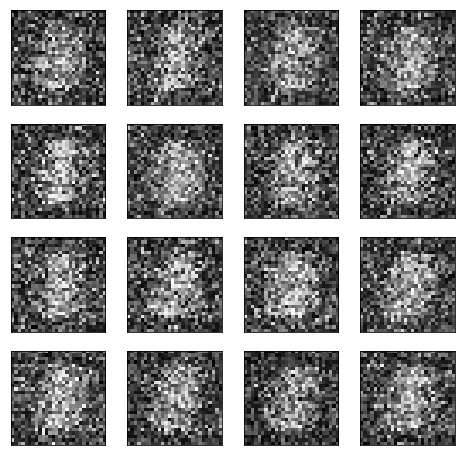

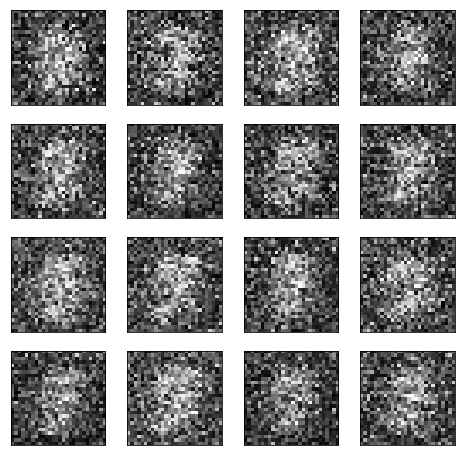

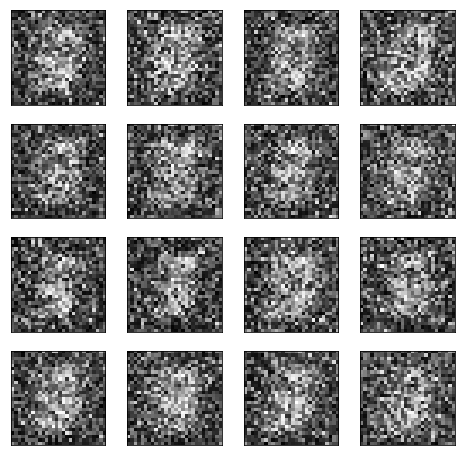

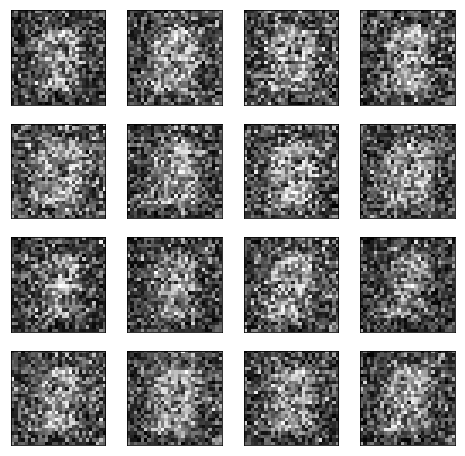

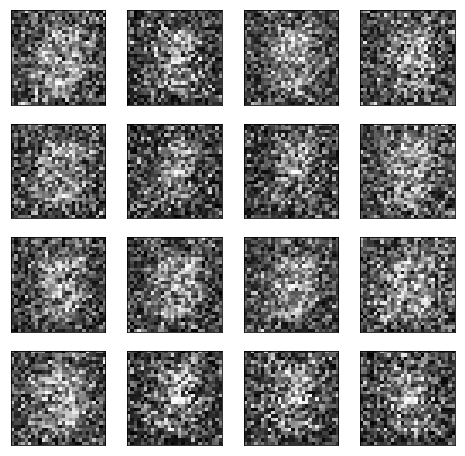

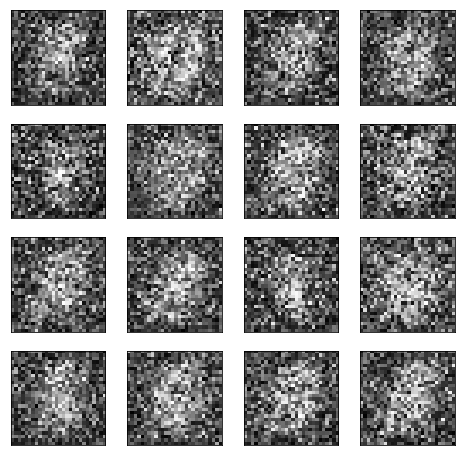

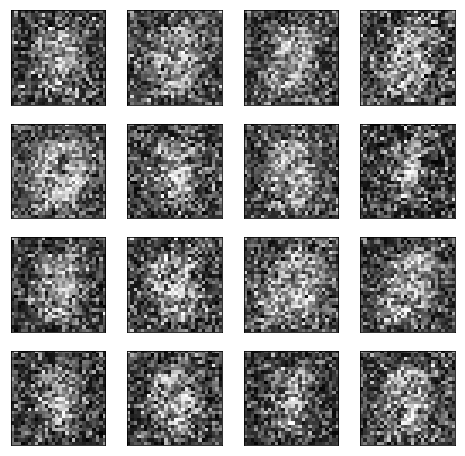

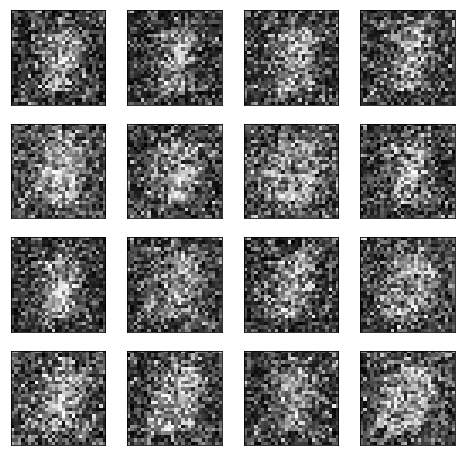

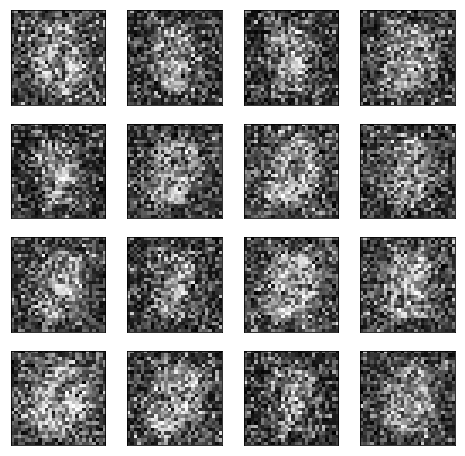

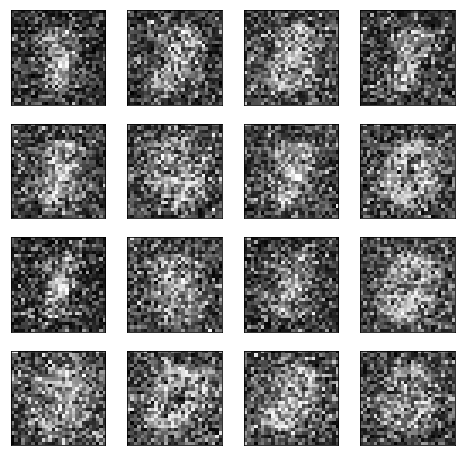

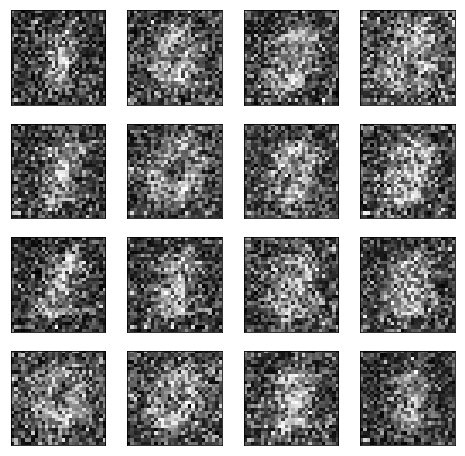

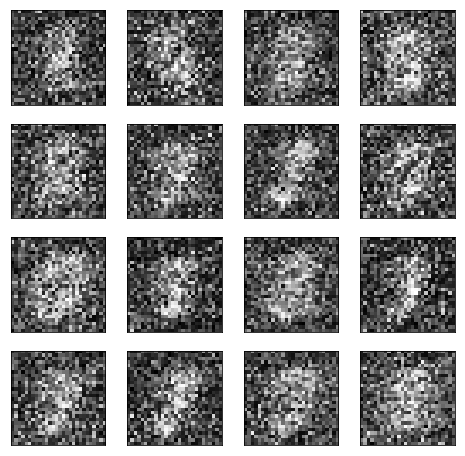

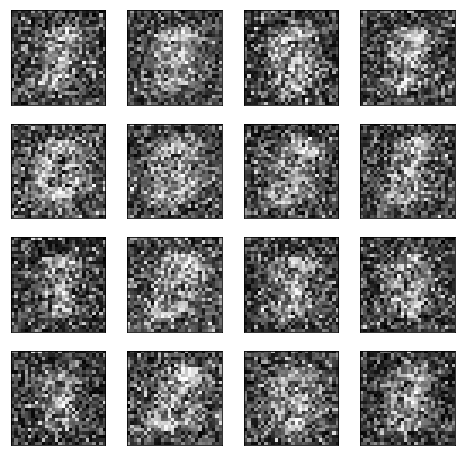

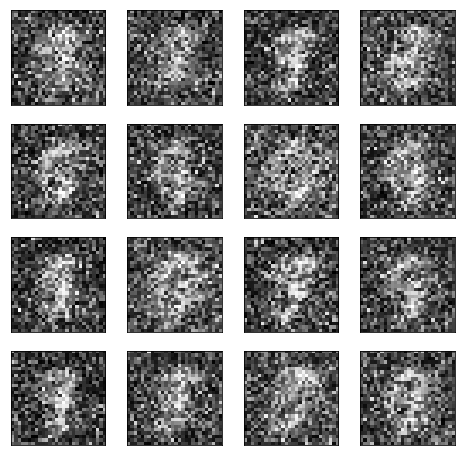

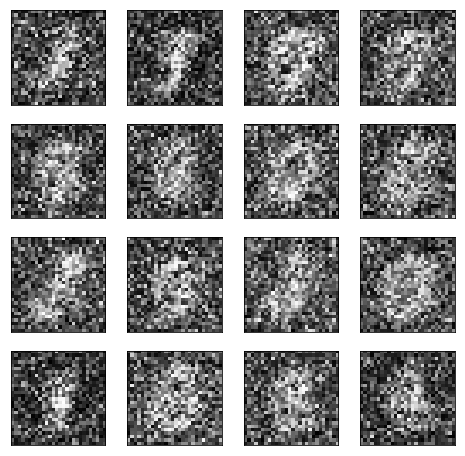

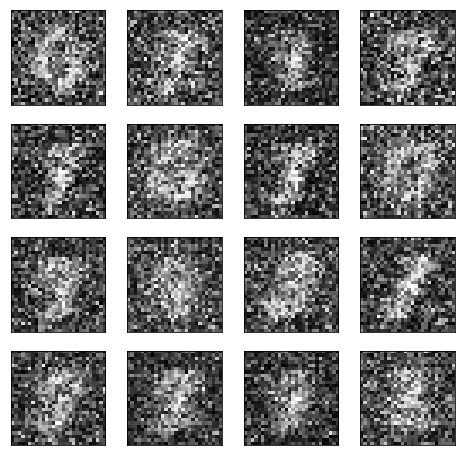

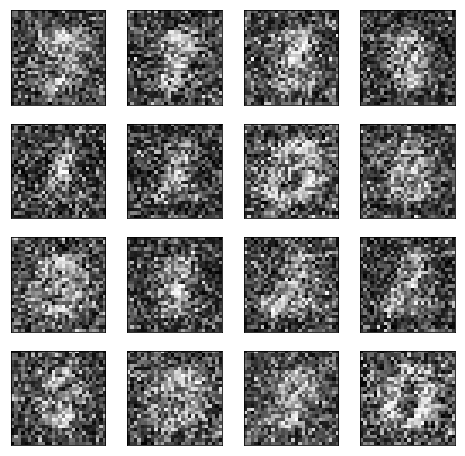

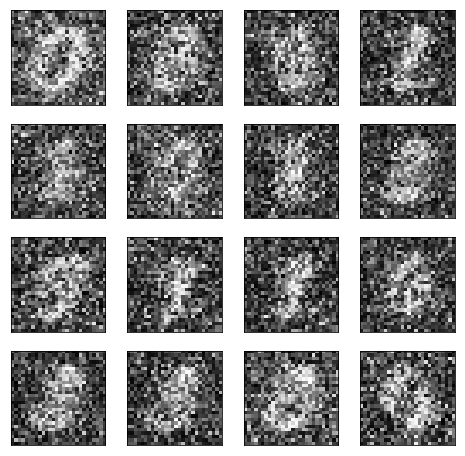

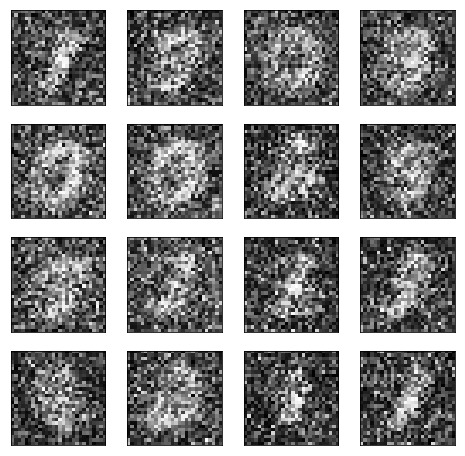

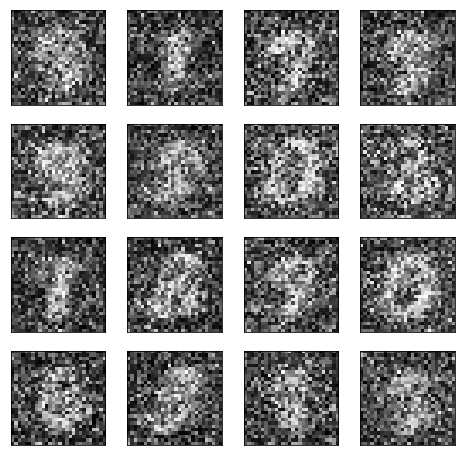

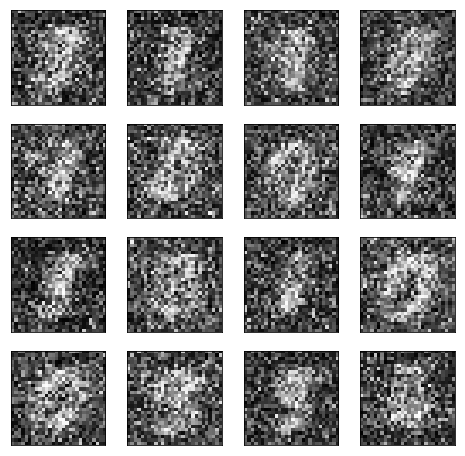

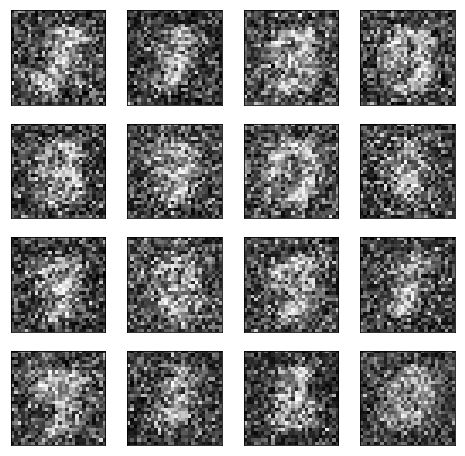

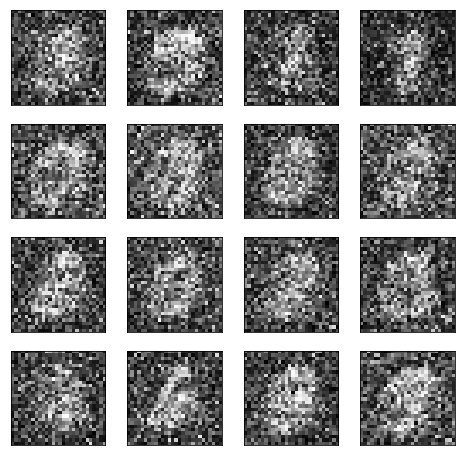

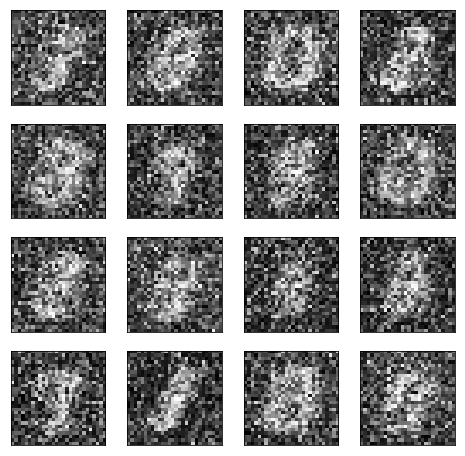

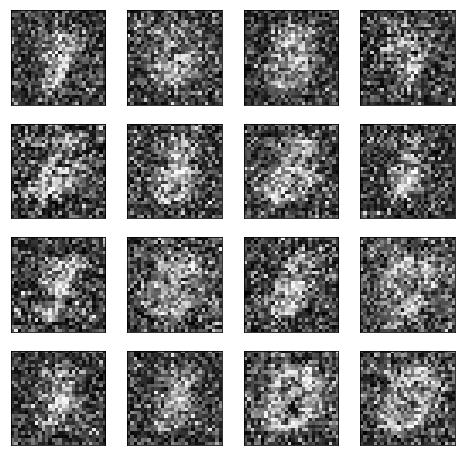

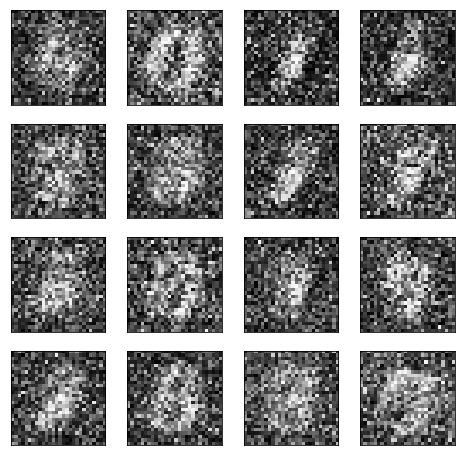

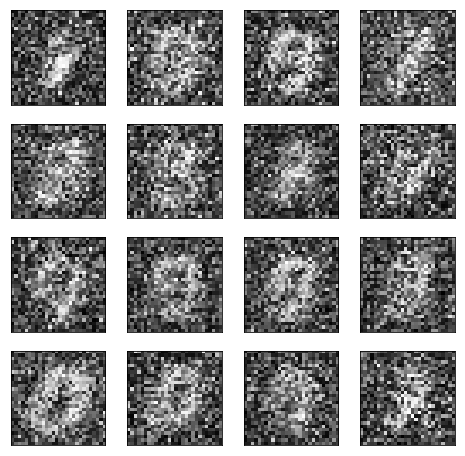

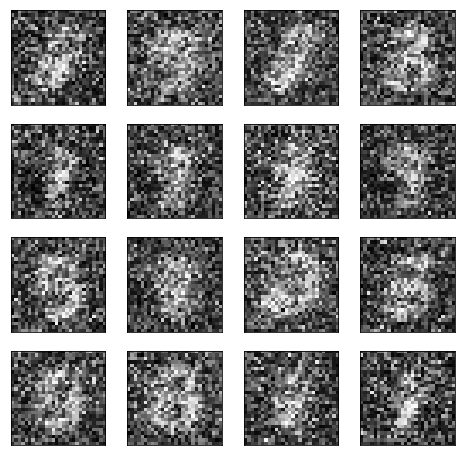

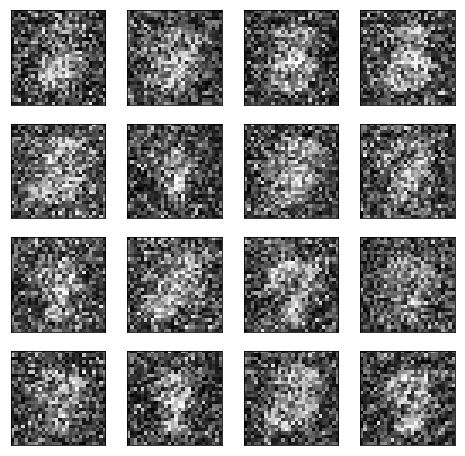

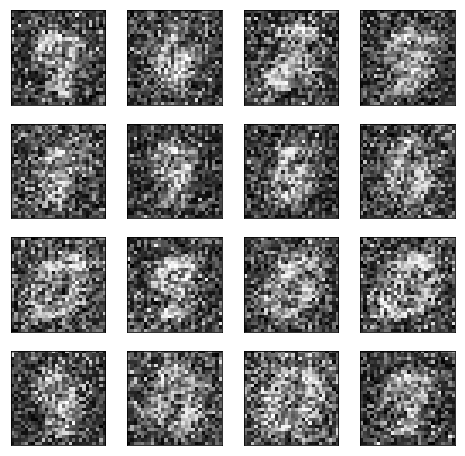

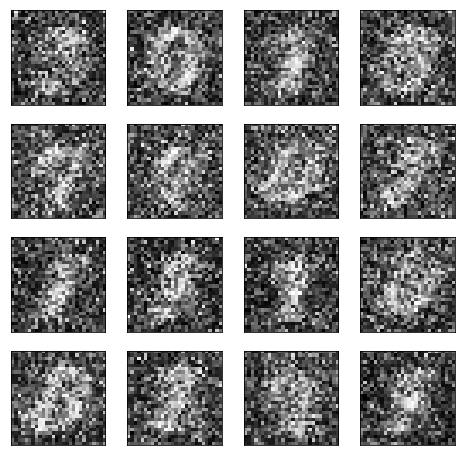

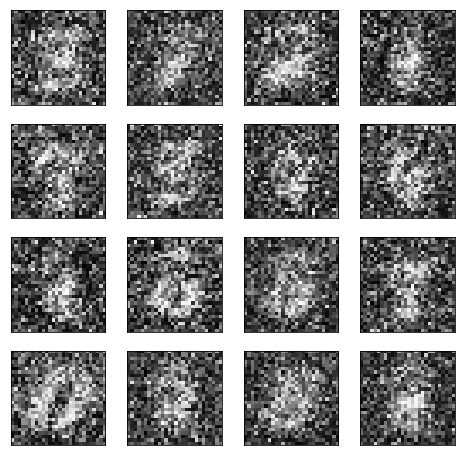

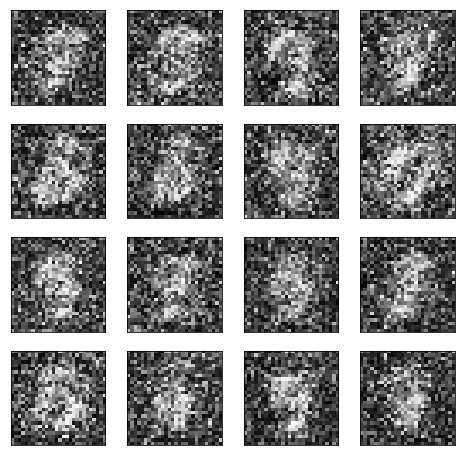

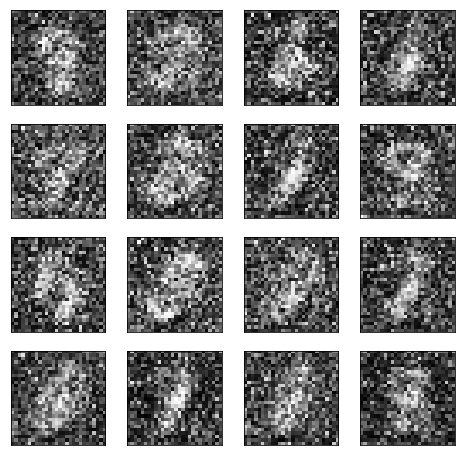

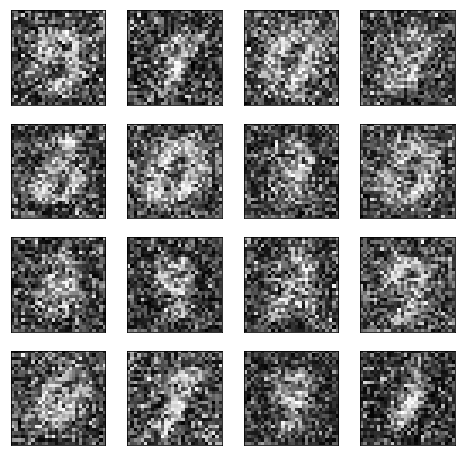

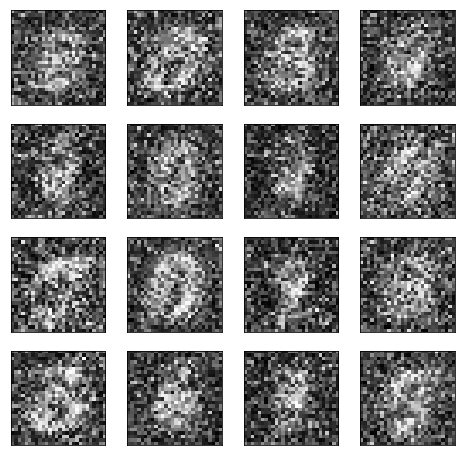

In [58]:
start = 0
epochs = 500
runAdversialNet(epochs, 32, lossDE, lossGE, accuDE, accuGE, start)
testGenerator(16, 4, 4, start)

fig = plt.figure()
plt.plot(lossDE, 'r')
plt.plot(lossGE, 'g')
fig.savefig(str(epoch)+'_loss.png')

# Test Generator

In [ ]:
testGenerator(16, 4, 4, 10, 600)

# Plotting loss

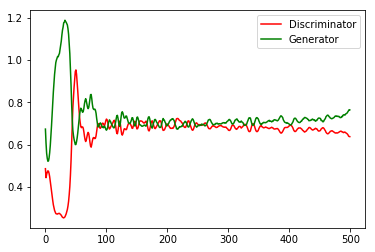

In [59]:
fig = plt.figure()
plt.plot(lossDE, 'r')
plt.plot(lossGE, 'g')
plt.legend(['Discriminator', 'Generator'])
fig.savefig(str(1000)+'_loss.png')